# Connecting stations on an empty graph

We want to be able to apply graph theory to bike stations for rebalancing purposes. One problem is that there isn't any clear link between stations that can translate itself into edges on a graph. This notebook shows how a naïve nearest neighbour algorithm can be used to connect stations in Toulouse.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import requests

The positions of the bike stations can be obtained with the OpenBikes API.

In [2]:
payload = {'city_slug': 'toulouse'}
stations = requests.get('http://api.openbikes.co/stations', params=payload).json()

[NetworkX](https://networkx.github.io/) is the go to library for manipulating graphs in Python. Let's first initialize an empty graph and fill it with it stations.

In [3]:
G = nx.Graph()

for station in stations:
    G.add_node(station['name'], pos=(station['longitude'], station['latitude']))

At this point none of the stations/nodes are connected. NetworkX works well with Matplotlib for representing a graph on a chart.

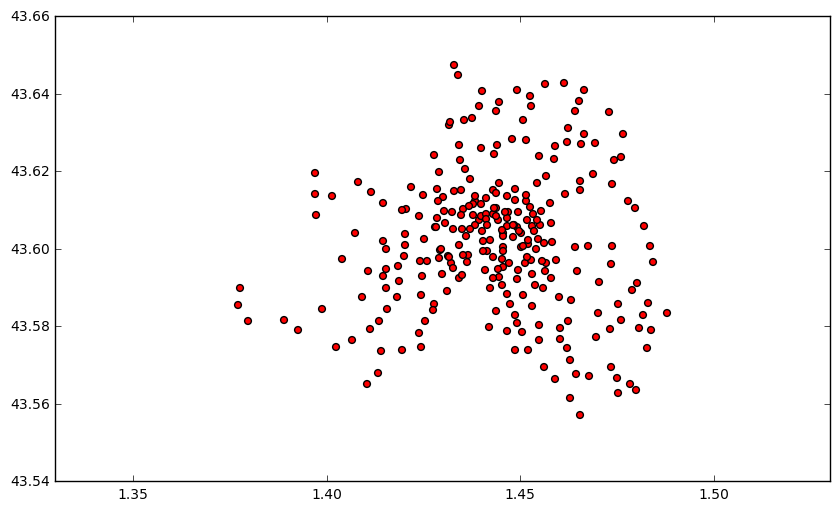

In [4]:
positions = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 6))
plt.axis('equal')
nx.draw_networkx(G, positions, node_size=24, with_labels=False)

A first intuition is to connect each station it's closest neighbour. For the sake of example we are going to use the euclidean distance; obtaining the true distance with, for example, the Google Distance Matrix is a tedious task. The algorithm is quite simple. We iterate over each node in the graph and reiterate over the nodes in order to find the closest node.

In [5]:
def euclidean_distance(node_a, node_b):
    dx = node_a['pos'][1] - node_b['pos'][1]
    dy = node_a['pos'][0] - node_b['pos'][0]
    return (dx ** 2 + dy ** 2) ** 1/2

for n1, d1 in G.nodes_iter(data=True):
    minimum = 10e9 # Very big value
    neighbour = None
    for n2, d2 in G.nodes_iter(data=True):
        # No need to compare a station to itself
        if n1 != n2:
            distance = euclidean_distance(d1, d2)
            if distance < minimum:
                minimum = distance
                neighbour = n2
    G.add_edge(n1, neighbour)

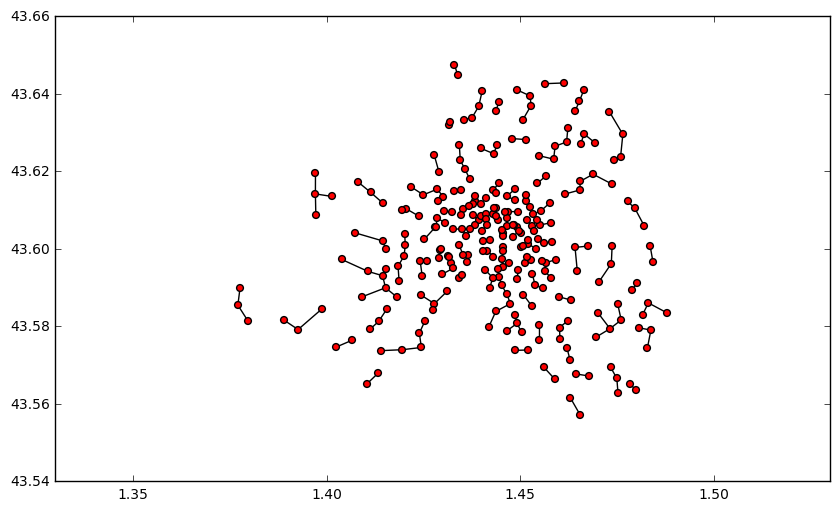

In [6]:
plt.figure(figsize=(10, 6))
plt.axis('equal')
nx.draw_networkx(G, positions, node_size=24, with_labels=False)

As can be seen, the graph is not fully connected. This is because if station $s1$ has for closest station $s2$ and reciprocally, then searching for a connection for $s1$ will be the same as doing so for $s2$. A trick that comes to mind is to connect "islands" the same way as previously.

In [7]:
iterations = 0

while not nx.is_connected(G):
    iterations += 1
    print('Iterations: {}'.format(iterations))
    for i, A in enumerate(nx.connected_components(G)):
        minimum = 10e9
        pair = None
        for j, B in enumerate(nx.connected_components(G)):
            if i != j:
                for a in A:
                    for b in B:
                        distance = euclidean_distance(G.node[a], G.node[b])
                        if distance < minimum:
                            minimum = distance
                            pair = [a, b]
        G.add_edge(pair[0], pair[1])

Iterations: 1
Iterations: 2
Iterations: 3
Iterations: 4
Iterations: 5
Iterations: 6
Iterations: 7
Iterations: 8
Iterations: 9
Iterations: 10
Iterations: 11
Iterations: 12
Iterations: 13
Iterations: 14
Iterations: 15
Iterations: 16
Iterations: 17
Iterations: 18
Iterations: 19
Iterations: 20
Iterations: 21
Iterations: 22


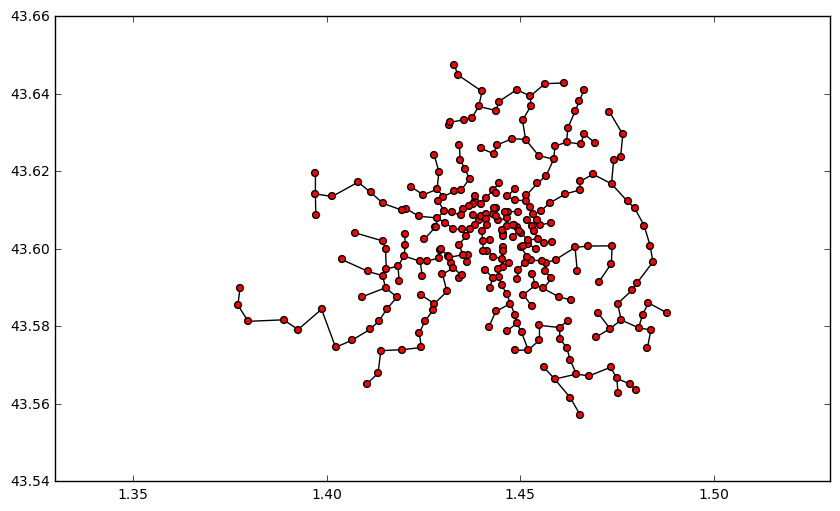

In [8]:
plt.figure(figsize=(10, 6))
plt.axis('equal')
nx.draw_networkx(G, positions, node_size=24, with_labels=False)

In [9]:
print(nx.is_connected(G))

True
